# Calibration of a 2 theta arm with a Pilatus 300kw detector

The aim of this document is to explain how to use pyFAI.goniometer for calibrating the position of the detector from the goniometer encoders at SSRL.

Those data have been acquired at 7-2 at SSRL in March 2018 by Natalie Geise using a Pilatus 300kw detector and LaB6 as calibrant. 61 images have been acquired in theta-two theta geometry from th = 2.5 and tth = 5 to th = 19.5 and tth = 39 degrees. The motor positions are registered in the .pdi files and in the .csv file for the entire scan.

A prior manual calibration (using pyFAI-calib2) has been performed on 5 images - scans 9, 23, 32, 43, 50. Those images had ring each in them (1,3,5,7,9 th rings). The control points extrated during this initial calibration has been used as a starting point for this calibration. Then more images have been added to make the model more robust.

from http://www.silx.org/doc/pyFAI/dev/usage/tutorial/Goniometer/Rotation-Pilatus100k/Multi120_Pilatus100k.html

edited by Natalie Geise - May 2018





To adapt you need to:
-adjust alignment folder
-put csv file in alignment folder, make sure the right column in the csv file is being used (this is noted in the code in the functon get angle)
-rough manual calibration for a few images/rings (use image-j to convert raw to tif, then used pyfai-calib2 to calibrate - save poni files and .npt which contains the control points (marked points along rings that you id'ed) in alignment folder
-check size of imgs - should be the detector size 
    pilatus 300kw is 
    w = 1475
    h = 195
    pilatus 100k is
    w = 495
    h = 195

In [3]:

#folder with poni and raw data files and csv files
raw_alignment_folder = "C:\\Users\\Natalie\\Documents\\Research - Toney\\Data\\alignment test files\\Lab6\\tth"

#size of imgs
w = 1475
h = 195

#scan factors Could be changed to read pdi files
"""th_start = 5
th_end = 50
no_scans = 61""" # = number entered in spec + 1

wavelength = 8.85601409974337e-11

'th_start = 5\nth_end = 50\nno_scans = 61'

In [4]:
# Initialization of the plotting library to be used with the jupyter notebook

%pylab nbagg
import nbformat

import os
#Loading of a few libraries
import os
import glob
import random
import fabio
import pyFAI
from pyFAI.goniometer import GeometryTranslation, GoniometerRefinement, Goniometer
from pyFAI.gui import jupyter


#making sure we are in the right folder and seeing your files
all_files = os.listdir(raw_alignment_folder)
print([os.path.basename(i) for i in all_files])

Populating the interactive namespace from numpy and matplotlib
['b_toney_Lab6_thtth_rightside_scan2_0000.raw', 'b_toney_Lab6_thtth_rightside_scan2_0000.raw.pdi', 'b_toney_Lab6_thtth_rightside_scan2_0001.raw', 'b_toney_Lab6_thtth_rightside_scan2_0001.raw.pdi', 'b_toney_Lab6_thtth_rightside_scan2_0002.raw', 'b_toney_Lab6_thtth_rightside_scan2_0002.raw.pdi', 'b_toney_Lab6_thtth_rightside_scan2_0003.raw', 'b_toney_Lab6_thtth_rightside_scan2_0003.raw.pdi', 'b_toney_Lab6_thtth_rightside_scan2_0004.raw', 'b_toney_Lab6_thtth_rightside_scan2_0004.raw.pdi', 'b_toney_Lab6_thtth_rightside_scan2_0005.raw', 'b_toney_Lab6_thtth_rightside_scan2_0005.raw.pdi', 'b_toney_Lab6_thtth_rightside_scan2_0006.raw', 'b_toney_Lab6_thtth_rightside_scan2_0006.raw.pdi', 'b_toney_Lab6_thtth_rightside_scan2_0007.raw', 'b_toney_Lab6_thtth_rightside_scan2_0007.raw.pdi', 'b_toney_Lab6_thtth_rightside_scan2_0008.raw', 'b_toney_Lab6_thtth_rightside_scan2_0008.raw.pdi', 'b_toney_Lab6_thtth_rightside_scan2_0009.npt', 'b_tone

C:\Users\Natalie\Anaconda2\envs\python3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [5]:
#function to read the raw files that SSRL saves
def read_raw(fn, w, h):
    try:
        with open(fn, 'r') as f:
            img = np.fromfile(f, dtype=np.int32)
        img = np.reshape(img, (h,w), order='C')
        return img
    except:
        print("Error reading file: %s" % fn)
        return(None)

List of images: b_toney_Lab6_thtth_rightside_scan2_0000.raw, b_toney_Lab6_thtth_rightside_scan2_0001.raw, b_toney_Lab6_thtth_rightside_scan2_0002.raw, b_toney_Lab6_thtth_rightside_scan2_0003.raw, b_toney_Lab6_thtth_rightside_scan2_0004.raw, b_toney_Lab6_thtth_rightside_scan2_0005.raw, b_toney_Lab6_thtth_rightside_scan2_0006.raw, b_toney_Lab6_thtth_rightside_scan2_0007.raw, b_toney_Lab6_thtth_rightside_scan2_0008.raw, b_toney_Lab6_thtth_rightside_scan2_0009.raw, b_toney_Lab6_thtth_rightside_scan2_0010.raw, b_toney_Lab6_thtth_rightside_scan2_0011.raw, b_toney_Lab6_thtth_rightside_scan2_0012.raw, b_toney_Lab6_thtth_rightside_scan2_0013.raw, b_toney_Lab6_thtth_rightside_scan2_0014.raw, b_toney_Lab6_thtth_rightside_scan2_0015.raw, b_toney_Lab6_thtth_rightside_scan2_0016.raw, b_toney_Lab6_thtth_rightside_scan2_0017.raw, b_toney_Lab6_thtth_rightside_scan2_0018.raw, b_toney_Lab6_thtth_rightside_scan2_0019.raw, b_toney_Lab6_thtth_rightside_scan2_0020.raw, b_toney_Lab6_thtth_rightside_scan2_0021

<IPython.core.display.Javascript object>


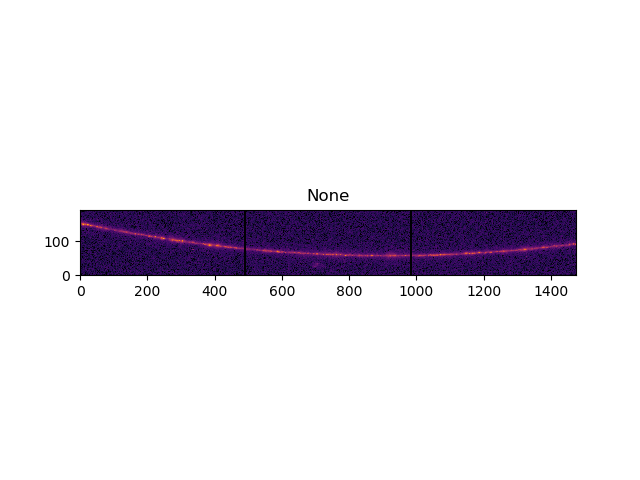

In [6]:
#loading of the list of raw files
os.chdir(raw_alignment_folder)
raw_files = glob.glob("*.raw")
raw_files.sort()
print("List of images: " + ", ".join(raw_files) + "." + os.linesep)

#displays last image (might be upside down which is okay)
fimg = read_raw(raw_files[-1], w, h)
jupyter.display(fimg)



In [41]:
#Definition of the goniometer translation function:
# The detector rotates vertically, around the horizontal axis, i.e. rot2, 
# allows some rotation of rot 1 and rot 3, but these are usually small if the arm/motor is functioning as it should


goniotrans = GeometryTranslation(param_names = ["dist", 
                                                "poni1",
                                                "poni2",
                                                 "rot1", "rot1_scale",
                                                 "rot2_offset", "rot2_scale", 
                                                 "rot3", "rot3_scale"],
                                  dist_expr="dist", 
                                  poni1_expr="poni1",
                                  poni2_expr="poni2", 
                                  rot1_expr="rot1_scale * pos + rot1", 
                                  rot2_expr="rot2_scale * pos + rot2_offset", 
                                  rot3_expr="rot3_scale * pos + rot3")

#gets angle from csv file
def get_angle(basename):
    """Takes the basename (b_toney_scanname_scan1_0001 ) and returns the angle of the detector by looking up in the csv file"""
    #pretty sure there is a more concise way to extract this info 
    import csv
    group     = str(basename.split("_")[1])
    #print(group)
    
    #parses and puts file name back together in case there were _ in the file name
    scan_parse = (basename.split("_")[2:-2])
    #print(scan_parse)
    scan_name = ""
    for i, p in enumerate(list(scan_parse)):
        if i == 0 :
            scan_name = scan_name + p
        if i >= 1:
            scan_name = scan_name + "_" + p
    #print(scan_name)
    scan_no   = str(basename.split("_")[-2])
    img_no    = int((basename.split("_")[-1]).split(".")[0])
    
    filename  = scan_name + "_" + scan_no
    angle = filename
    #print(filename)
    #print(img_no)
    csvfile = filename + ".csv"
    with open(csvfile, 'r') as csvfile:
        csvfile = csv.reader(csvfile)
        for i, row in enumerate(csvfile):
            #print(i)
            #print(row[1])
            if i == (img_no + 1):
                ##############################check here that correct column from csv file is used: 1 for second column, 2 for the third
                angle = float(row[2])
                #print(angle)
    return angle

print("angle =", get_angle(raw_files[-1]))


angle = 39.0


In [42]:
#Definition of the detector, its mask, the calibrant

#mask1 = fabio.open("deviation-mask.edf").data
#mask2 = fabio.open("minimum-mask.edf").data
#mask = numpy.logical_or(mask1, mask2)


pilatus = pyFAI.detector_factory("Pilatus300kw")
print(pilatus)
#pilatus.mask = mask
    
LaB6 = pyFAI.calibrant.CALIBRANT_FACTORY("LaB6")
LaB6.wavelength = wavelength

Detector Pilatus 300kw	 PixelSize= 1.720e-04, 1.720e-04 m


In [54]:
#Definition of the geometry refinement: the parameter order is the same as the param_names

#adjust the param hints
param = {"dist":0.9, 
         "poni1":0.02, 
         "poni2":0.04, 
         "rot1":0,
         "rot1_scale":0,
         "rot2_offset":0,
         "rot2_scale": numpy.pi/180., # rot2 is in radians, while the motor position is in degrees
         "rot3":0,
         "rot3_scale":0
         
        }
#Defines the bounds for some variables
bounds = {"dist": (0.6, 1.3),
          #"rot1": (-0.3, 0.03),
          #"rot2_offset": (-0.1, 0.1),
          #"rot2_scale": (numpy.pi/180., numpy.pi/180.)
          #strict bounds on the scale: we expect the gonio to be precise
         }
gonioref = GoniometerRefinement(param, #initial guess
                                bounds=bounds,
                                pos_function=get_angle,
                                trans_function=goniotrans,
                                detector=pilatus,
                                wavelength=wavelength)
print("Empty refinement object:")
print(gonioref)

Empty refinement object:
GoniometerRefinement with 0 geometries labeled: .


In [55]:
#Let's populate the goniometer refinement object with all control point files:

ponis = glob.glob("*.poni")
ponis.sort()
for fn in ponis:
    base = os.path.splitext(fn)[0]
    print(base)
    fimg = read_raw(base + ".raw", w, h)
    #jupyter.display(img)
    sg = gonioref.new_geometry(base, image=fimg, metadata=base, control_points=base+".npt",
                              geometry=fn, calibrant=LaB6)
    print(base, "Angle:", sg.get_position())
    print(sg.geometry_refinement)
    print
    

print("Filled refinement object:")
print(gonioref)


b_toney_Lab6_thtth_rightside_scan2_0009
b_toney_Lab6_thtth_rightside_scan2_0009 Angle: 11.12
Detector Pilatus 300kw	 PixelSize= 1.720e-04, 1.720e-04 m
Wavelength= 8.856014e-11m
SampleDetDist= 4.384366e-01m	PONI= 1.057600e-01, 5.343496e-01m	rot1=0.675045  rot2= 0.026569  rot3= 0.000000 rad
DirectBeamDist= 561.808mm	Center: x=1066.174, y=701.655 pix	Tilt=38.702 deg  tiltPlanRotation= 177.565 deg
b_toney_Lab6_thtth_rightside_scan2_0023
b_toney_Lab6_thtth_rightside_scan2_0023 Angle: 20.64
Detector Pilatus 300kw	 PixelSize= 1.720e-04, 1.720e-04 m
Wavelength= 8.856014e-11m
SampleDetDist= 5.296471e-01m	PONI= 3.063571e-01, -2.474309e-01m	rot1=-0.544950  rot2= -0.067461  rot3= 0.000003 rad
DirectBeamDist= 620.771mm	Center: x=428.079, y=1537.854 pix	Tilt=31.438 deg  tiltPlanRotation= -7.426 deg
b_toney_Lab6_thtth_rightside_scan2_0032
b_toney_Lab6_thtth_rightside_scan2_0032 Angle: 26.76
Detector Pilatus 300kw	 PixelSize= 1.720e-04, 1.720e-04 m
Wavelength= 8.856014e-11m
SampleDetDist= 6.659066e-01

()


<IPython.core.display.Javascript object>


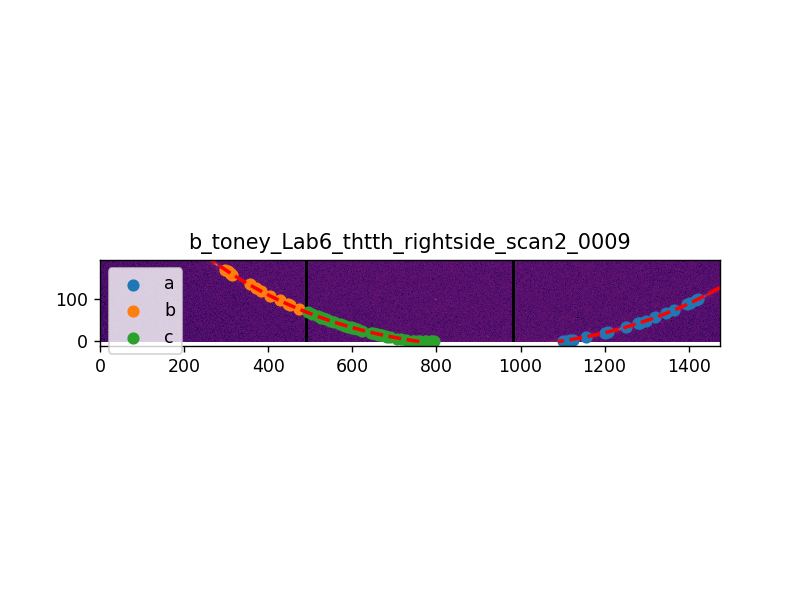

<IPython.core.display.Javascript object>


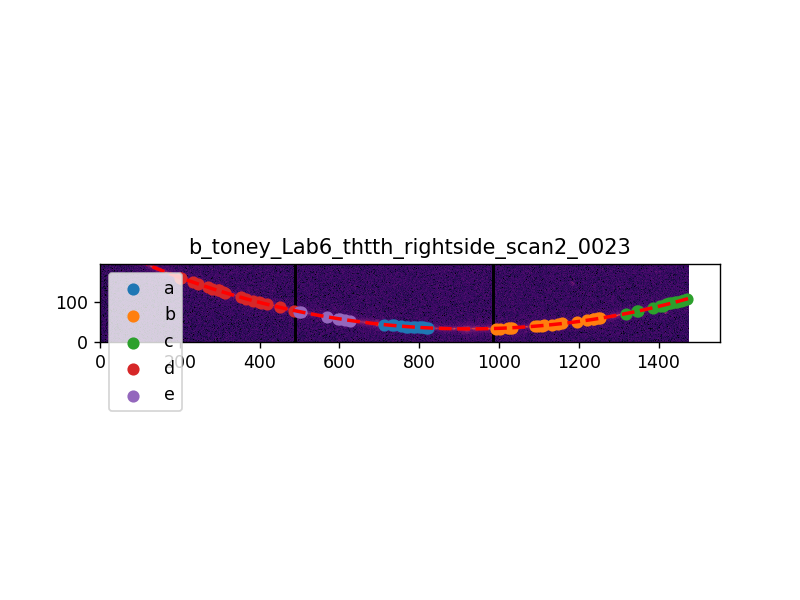

<IPython.core.display.Javascript object>


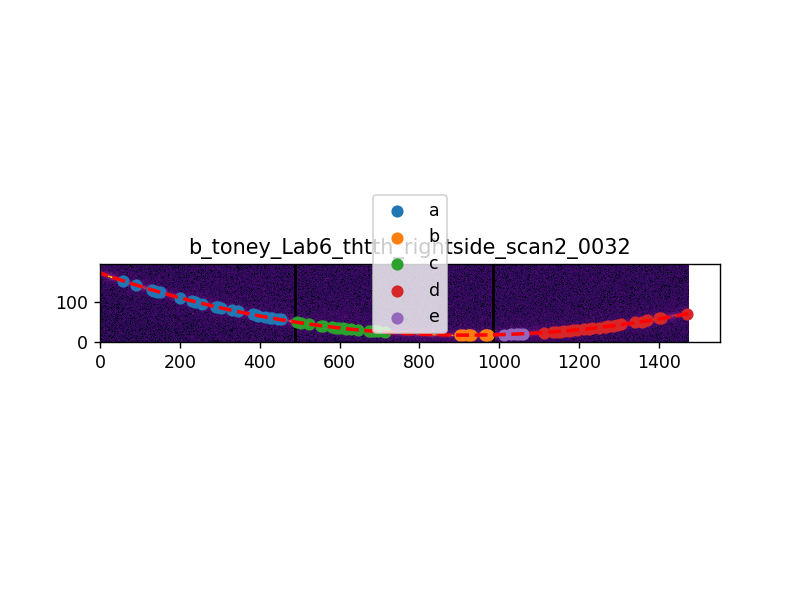

<IPython.core.display.Javascript object>


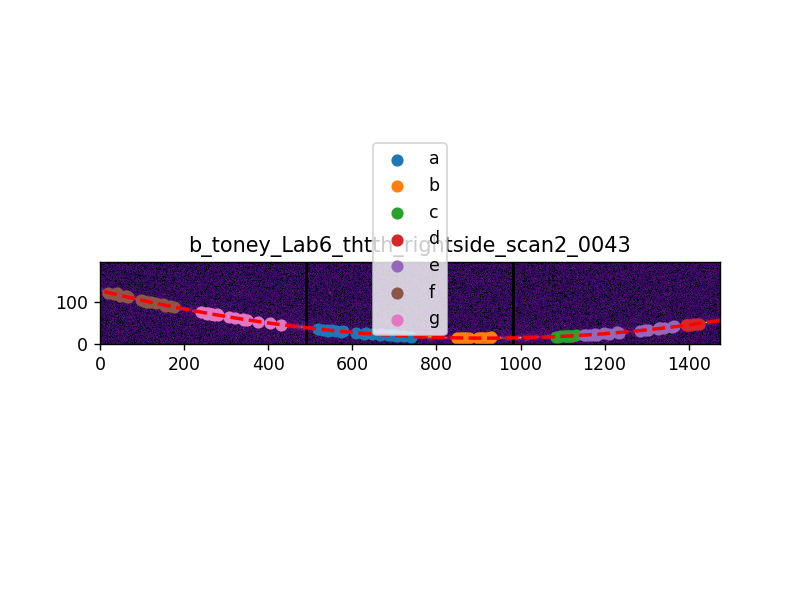

<IPython.core.display.Javascript object>


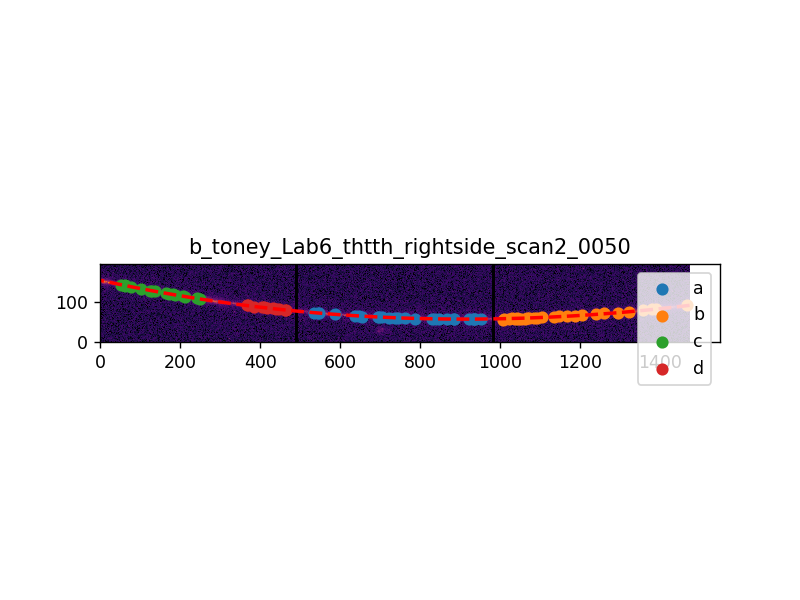

In [56]:
#Display all images with associated calibration:
print(np.shape(gonioref.single_geometries.values()))
for sg in gonioref.single_geometries.values():
    #print(sg)
    #print(sg.geometry_refinement.data)
    jupyter.display(sg=sg)

In [57]:
# Initial refinement of the goniometer model with 5 dof
gonioref.refine2()

Cost function before refinement: 0.0006963484896566161
[0.9        0.02       0.04       0.         0.         0.
 0.01745329 0.         0.        ]
     fun: 2.4910036893487722e-08
     jac: array([-3.22885767e-07, -2.80981431e-08,  5.65061482e-08, -5.00445283e-08,
       -3.95593170e-07, -2.46756398e-08, -1.49613338e-06,  4.37427872e-14,
       -6.10622664e-14])
 message: 'Optimization terminated successfully.'
    nfev: 216
     nit: 19
    njev: 19
  status: 0
 success: True
       x: array([ 9.14792953e-01,  1.61449088e-02,  1.03996430e-01, -6.00059829e-02,
        5.67402729e-05, -5.80462833e-04,  1.74561097e-02, -1.81174313e-10,
        2.19798602e-10])
Cost function after refinement: 2.4910036893487722e-08
GonioParam(dist=0.9147929527319121, poni1=0.016144908832987654, poni2=0.10399643045626032, rot1=-0.06000598292643023, rot1_scale=5.674027293358262e-05, rot2_offset=-0.0005804628327953117, rot2_scale=0.01745610974054106, rot3=-1.8117431259992433e-10, rot3_scale=2.1979860236473

array([ 9.14792953e-01,  1.61449088e-02,  1.03996430e-01, -6.00059829e-02,
        5.67402729e-05, -5.80462833e-04,  1.74561097e-02, -1.81174313e-10,
        2.19798602e-10])

In [58]:
# This function adds new images to the pool of data used for the refinement.
# A set of new control points are extractred and a refinement step is performed at each iteration
# The last image of the serie is displayed 

def optimize_with_new_images(list_images, pts_per_deg=1):
    sg = None
    for fname in list_images:
        print(fname)
        base = os.path.splitext(fname)[0]
        fimg = read_raw(base + ".raw", w, h)
        #print(fimg.shape)
        #print(gonioref.single_geometries)
        if base in gonioref.single_geometries:
            continue
        #print(fimg)
        sg = gonioref.new_geometry(base, image=fimg, metadata=base,#geometry=fn,
                                   calibrant=LaB6)
        #jupyter.display(sg=sg)
        print(sg.extract_cp(pts_per_deg=pts_per_deg))
    gonioref.refine2()
    if sg: 
        sg.geometry_refinement.set_param(gonioref.get_ai(sg.get_position()).param)
        jupyter.display(sg=sg)


['b_toney_Lab6_thtth_rightside_scan2_0030.raw', 'b_toney_Lab6_thtth_rightside_scan2_0031.raw', 'b_toney_Lab6_thtth_rightside_scan2_0032.raw', 'b_toney_Lab6_thtth_rightside_scan2_0033.raw', 'b_toney_Lab6_thtth_rightside_scan2_0034.raw', 'b_toney_Lab6_thtth_rightside_scan2_0035.raw', 'b_toney_Lab6_thtth_rightside_scan2_0036.raw', 'b_toney_Lab6_thtth_rightside_scan2_0037.raw', 'b_toney_Lab6_thtth_rightside_scan2_0038.raw', 'b_toney_Lab6_thtth_rightside_scan2_0039.raw']
b_toney_Lab6_thtth_rightside_scan2_0037.raw
ControlPoints instance containing 1 group of point:
LaB6 Calibrant with 75 reflections at wavelength 8.85601409974337e-11
Containing 1 groups of points:
# e ring 5: 93 points
b_toney_Lab6_thtth_rightside_scan2_0036.raw
ControlPoints instance containing 1 group of point:
LaB6 Calibrant with 75 reflections at wavelength 8.85601409974337e-11
Containing 1 groups of points:
# f ring 5: 99 points
b_toney_Lab6_thtth_rightside_scan2_0034.raw
ControlPoints instance containing 2 group of po

<IPython.core.display.Javascript object>


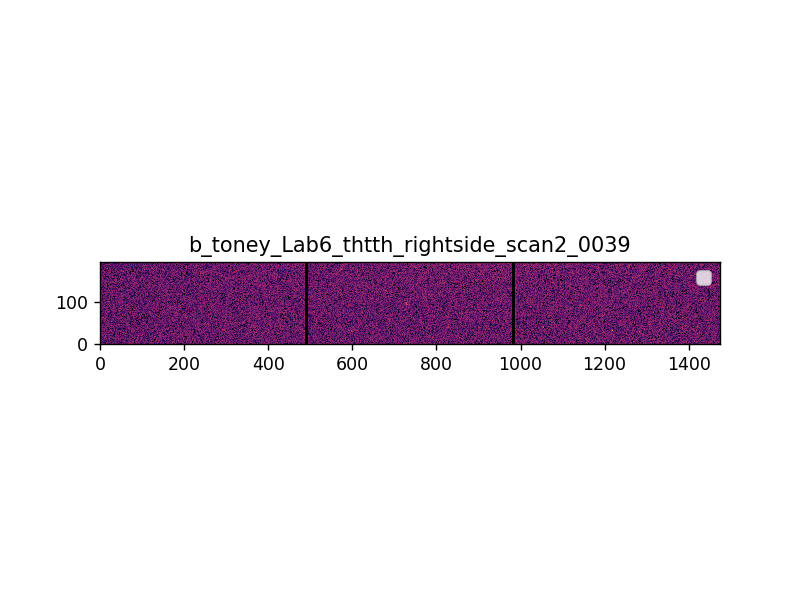

C:\Users\Natalie\Anaconda2\envs\python3\lib\site-packages\matplotlib\contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


In [59]:
# Append all other images bewteen 30 and 40 degrees
images_30_40 = glob.glob("*_003*.raw")
print((images_30_40))
random.shuffle(images_30_40)
optimize_with_new_images(images_30_40, pts_per_deg=3)

b_toney_Lab6_thtth_rightside_scan2_0026.raw
ControlPoints instance containing 1 group of point:
LaB6 Calibrant with 75 reflections at wavelength 8.85601409974337e-11
Containing 1 groups of points:
# o ring 3: 8 points
b_toney_Lab6_thtth_rightside_scan2_0012.raw
ControlPoints instance containing 1 group of point:
LaB6 Calibrant with 75 reflections at wavelength 8.85601409974337e-11
Containing 1 groups of points:
# p ring 0: 21 points
b_toney_Lab6_thtth_rightside_scan2_0042.raw
ControlPoints instance containing 1 group of point:
LaB6 Calibrant with 75 reflections at wavelength 8.85601409974337e-11
Containing 1 groups of points:
# q ring 6: 7 points
b_toney_Lab6_thtth_rightside_scan2_0022.raw
ControlPoints instance containing 1 group of point:
LaB6 Calibrant with 75 reflections at wavelength 8.85601409974337e-11
Containing 1 groups of points:
# r ring 2: 24 points
b_toney_Lab6_thtth_rightside_scan2_0000.raw
ControlPoints instance containing 0 group of point:
LaB6 Calibrant with 75 reflect

ControlPoints instance containing 1 group of point:
LaB6 Calibrant with 75 reflections at wavelength 8.85601409974337e-11
Containing 1 groups of points:
#ax ring 3: 22 points
b_toney_Lab6_thtth_rightside_scan2_0039.raw
b_toney_Lab6_thtth_rightside_scan2_0043.raw
b_toney_Lab6_thtth_rightside_scan2_0048.raw
ControlPoints instance containing 2 group of point:
LaB6 Calibrant with 75 reflections at wavelength 8.85601409974337e-11
Containing 2 groups of points:
#ay ring 7: 24 points
#az ring 8: 4 points
Cost function before refinement: 2.117063461323581e-08
[ 9.18519474e-01  1.62022806e-02  1.03961986e-01 -5.97335827e-02
  4.80431942e-05 -5.45340178e-04  1.74538639e-02 -9.08140835e-11
  2.41800691e-10]
     fun: 2.0278252873650397e-08
     jac: array([ 3.87110886e-08, -3.61320329e-08, -1.11644008e-07, -9.88810414e-08,
       -5.48122392e-09, -3.60301711e-08, -2.27914745e-08, -7.99360578e-15,
       -3.66373598e-14])
 message: 'Optimization terminated successfully.'
    nfev: 93
     nit: 8
 

<IPython.core.display.Javascript object>


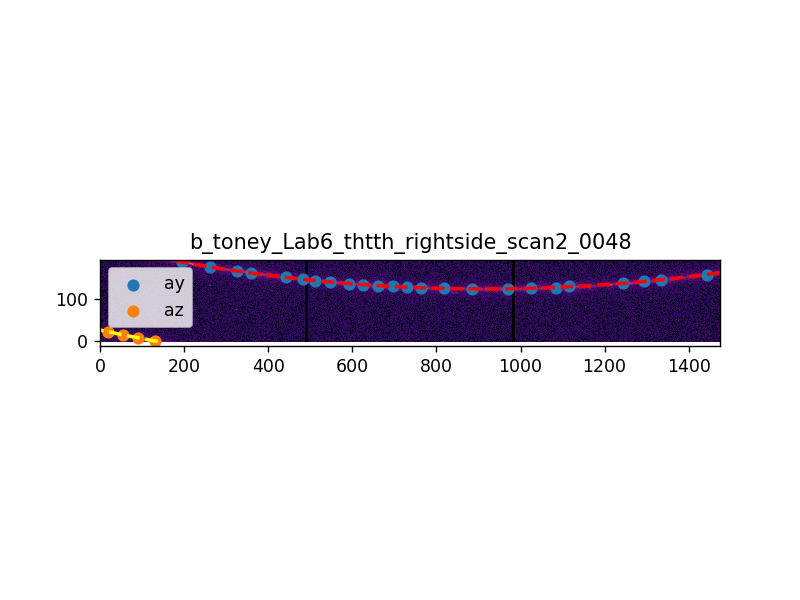

In [61]:
 # Append all other images

all_images = glob.glob("b_toney*.raw")
random.shuffle(all_images)
optimize_with_new_images(all_images)

First & last rings
Total number of images: 51


<IPython.core.display.Javascript object>


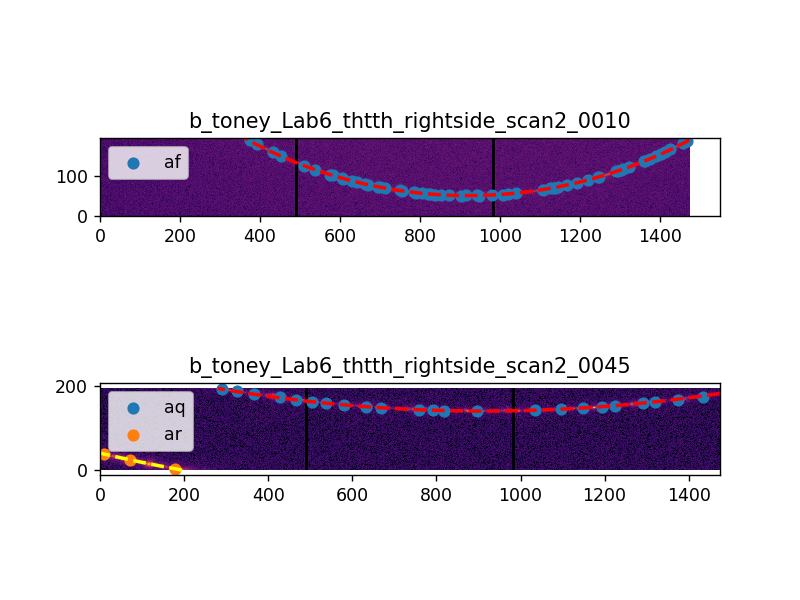

In [64]:
# Check the calibration of the first and the last image with rings

print("First & last rings")

print("Total number of images:", len(gonioref.single_geometries) )

fig = plt.figure()
for idx,lbl in enumerate(["b_toney_Lab6_thtth_rightside_scan2_0010", "b_toney_Lab6_thtth_rightside_scan2_0045"]):
    sg = gonioref.single_geometries[lbl]
    if sg.control_points.get_labels():
        sg.geometry_refinement.set_param(gonioref.get_ai(sg.get_position()).param)
    jupyter.display(sg=sg, ax=fig.add_subplot(2, 1, idx+1))
        


In [33]:
# Final pass of refinement with all constrains removed, very fine refinement

gonioref.bounds = None
gonioref.refine2("slsqp", eps=1e-13, maxiter=10000, ftol=1e-12)

Cost function before refinement: 2.038178781937088e-08
[ 9.18461432e-01  1.68595158e-02  1.03796187e-01 -5.97309140e-02
  8.24597894e-05 -1.31594680e-03  3.49110214e-02 -1.52491982e-10
 -1.59852905e-10]
     fun: 2.0381778319789317e-08
     jac: array([-9.13207396e-08, -1.42870635e-07, -1.35823057e-07, -7.34536384e-08,
       -1.52499018e-07, -1.10081196e-07, -2.51132034e-06, -4.89690923e-09,
       -8.07328278e-09])
 message: 'Optimization terminated successfully.'
    nfev: 15
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([ 9.18461433e-01,  1.68595163e-02,  1.03796187e-01, -5.97309138e-02,
        8.24602452e-05, -1.31594647e-03,  3.49110289e-02, -1.37857714e-10,
       -1.35726138e-10])
Cost function after refinement: 2.0381778319789317e-08
GonioParam(dist=0.9184614325688504, poni1=0.01685951625757774, poni2=0.10379618726686055, rot1=-0.05973091375724938, rot1_scale=8.246024517937248e-05, rot2_offset=-0.0013159464742721792, rot2_scale=0.034911028862640414, rot3=

array([ 9.18461433e-01,  1.68595163e-02,  1.03796187e-01, -5.97309138e-02,
        8.24602452e-05, -1.31594647e-03,  3.49110289e-02, -1.37857714e-10,
       -1.35726138e-10])

In [62]:
#Create a MultiGeometry integrator from the refined geometry:

angles = []
images = []
for sg in gonioref.single_geometries.values():
    angles.append(sg.get_position())
    images.append(sg.image)
    
multigeo = gonioref.get_mg(angles)
multigeo.radial_range=(.5,6.1)
multigeo.unit=("q_A^-1")
print(multigeo)

MultiGeometry integrator with 51 geometries on (0.5, 6.1) radial range (q_A^-1) and (-180, 180) azimuthal range (deg)


<IPython.core.display.Javascript object>


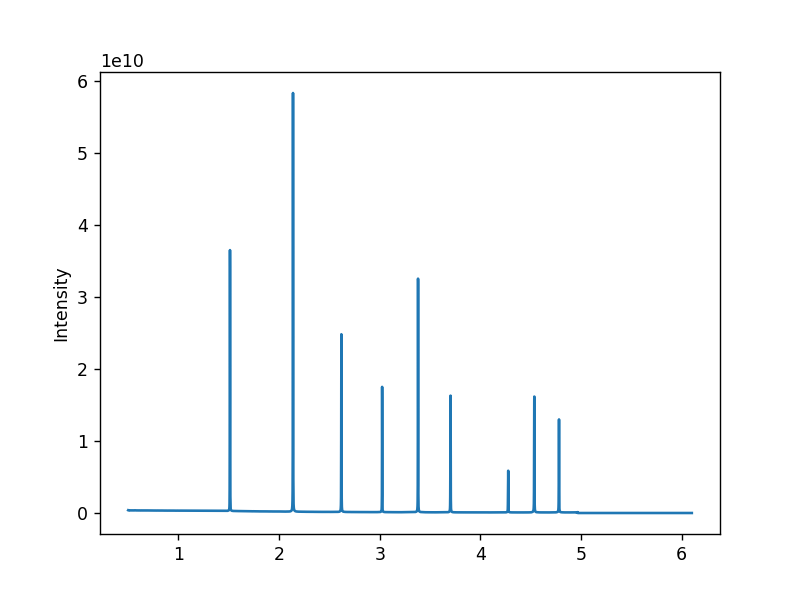

Text(0,0.5,'Intensity')

In [63]:
# Integrate the whole set of images in a single run:

res = multigeo.integrate1d(images, 10000)
fig, ax = subplots()
ax.plot(*res)
#ax.set_xlabel(res.unit.label)
ax.set_ylabel("Intensity")


In [65]:
# Save the goniometer configuration with 1 angle

gonioref.save("ROBL_v1.json")


# Conclusion

This notebook exposes the how to calibrate the goniometer for a detector moving on a 2theta arm. 
Once calibrated, the geometry can be saved and restored and stays valid as long as the detector or the goniometer is not unmounted from the beam-line. This configuration can subsequently be used to integrate the data acquired with any  sample, in minutes instead of hours. The resolution limit is now the pixel size.